In [2]:
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from functions_2 import *
import config_gen
from itertools import product
from skspatial.objects import Line,Points
import pandas as pd
import csv


#### sensor_parameters
dist_z = 8.5 # [mm] distance between planes
Lgap = 4.85 # GAP STAVE mm + addition distance for space compliance (mechanincal)
Sgap = 0.15 # GAP CHIP mm
width = 30 #width of the turrets [mm]
stavew=width+Sgap
ProbNoise = config_gen.ProbNoise
ProbMiss = config_gen.ProbMiss


Generatore di dataset:

In [ ]:
num_samples = config_gen.N_EVGEN
num_lines_per_plot = range(6, 11)

outfile =[f"C:\\Users\\lcdit\\OneDrive\\Desktop\\Uni\\Triennale\\Tesi\\data\\10k_{i}_tracks.csv" for i in range(6,11)]

for idx, file_path in enumerate(outfile):
    num_plots, num_gen_events = 0, 0
    cont = []
    while num_gen_events <= num_samples:
        point, direction = generate_random_line()  # Se volessi dare un punto specifico, modificare funzione
        points_on_line = get_points(direction, point, [0., -dist_z, -2*dist_z])

        if limiti_spaziali(points_on_line):
            num_plots += 1
            
            # points_on_line è Nx3, operiamo su righe per chiarezza
            points = points_on_line.reshape(-1, 3)

            # Identificare punti da rimuovere per missed_stave
            mask_missed = np.array([missed_stave(y, stavew, Lgap) for y in points[:,1]])

            # Elimina i punti 'missed_stave'
            points = points[~mask_missed]

            # Introduci rumore: rimuovi punti con probabilità ProbMiss
            if len(points) > 0:
                # Genera un array di random per ogni punto e filtra quelli da rimuovere
                rand_vals = np.random.uniform(0, 1, size=len(points))
                points = points[rand_vals >= ProbMiss]

            # Aggiorna points_on_line come Nx3
            points_on_line = points.reshape(-1, 3)

            cont.append(dati(num_gen_events, points_on_line, direction, point, num_plots))
            
            noise = noise_gen(ProbNoise, dist_z)
            cont.append(dati(num_gen_events, noise, np.zeros_like(direction), np.zeros_like(point), -1))

        if num_plots == (idx+6):
            num_plots = 0
            num_gen_events += 1
#        if num_gen_events%100 == 0:
#            print(num_gen_events)

    save_csv_py(cont, file_path)

Salvataggio direzione retta

In [16]:
import csv

outfile = "C:\\Users\\lcdit\\OneDrive\\Desktop\\Uni\\Triennale\\Tesi\\data\\directions_tracks.csv"
num_samples = 100000  # Assicurati che sia 10000

directions_list = []
num_gen_events = 0

while num_gen_events < num_samples:
    point, direction = generate_random_line()
    points_on_line = get_points(direction, point, [0., -dist_z, -2*dist_z])

    if limiti_spaziali(points_on_line):
        points = points_on_line.reshape(-1, 3)
        mask_missed = np.array([missed_stave(y, stavew, Lgap) for y in points[:, 1]])
        points = points[~mask_missed]

        if len(points) > 0:
            rand_vals = np.random.uniform(0, 1, size=len(points))
            points = points[rand_vals >= ProbMiss]

        if points.shape[0] > 0:
            directions_list.append(direction.tolist())
            num_gen_events += 1  # accetta solo se valido

# Scrittura CSV finale
with open(outfile, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['dx', 'dy', 'dz'])
    writer.writerows(directions_list)

Visualizzatore dati:

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


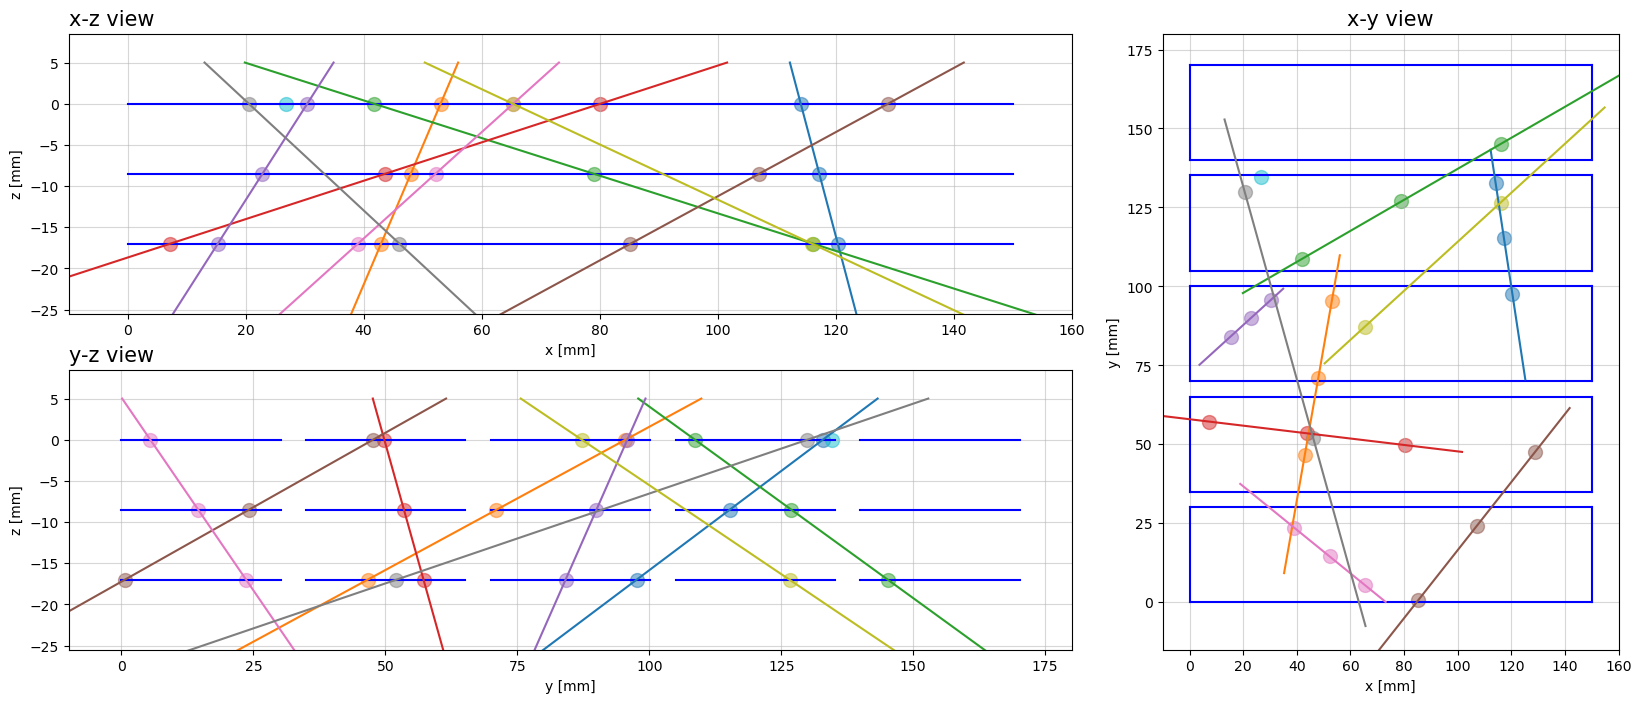

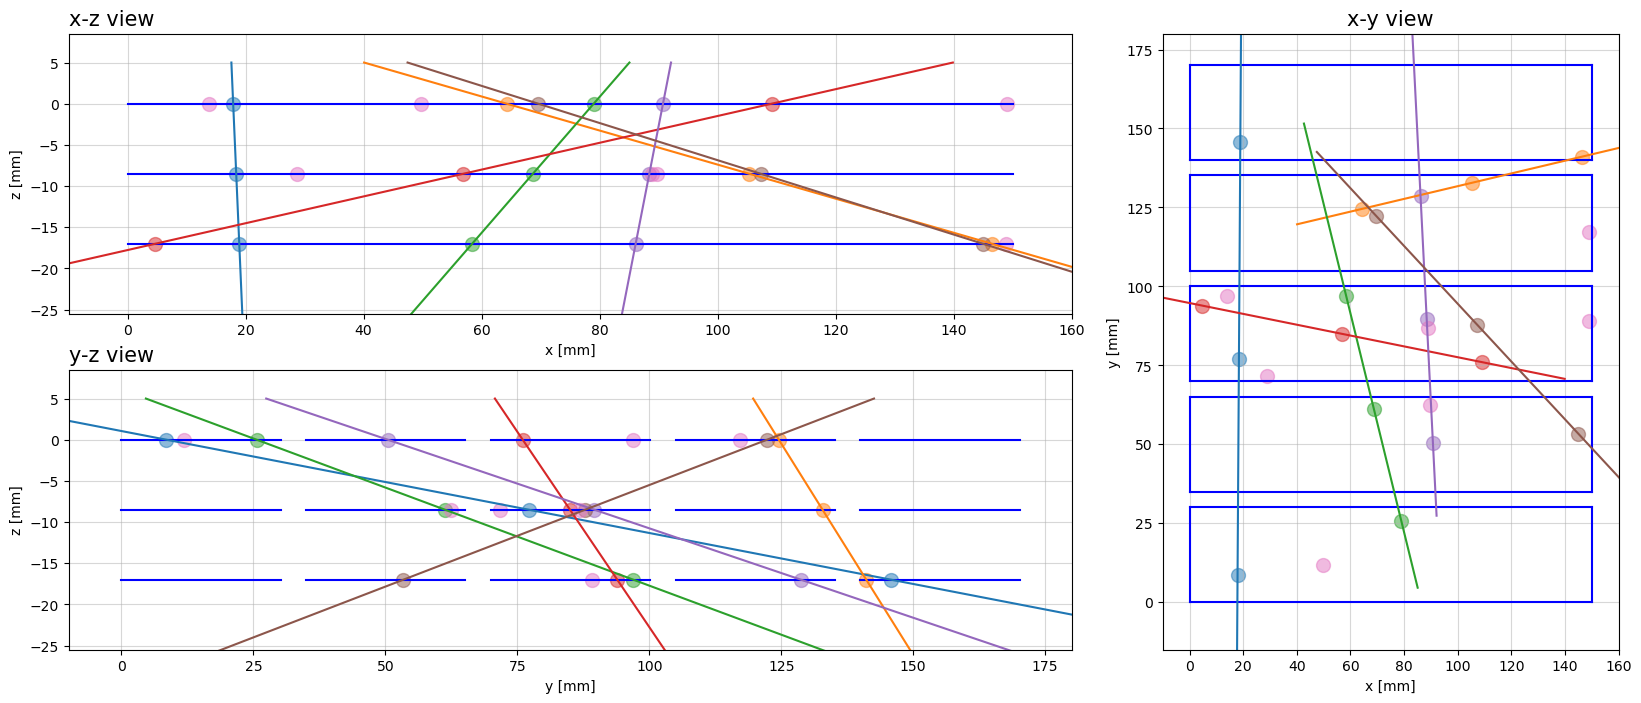

In [8]:

counter = 0
n_plot = 2
nome = '/home/luca/Uni/VI/Tesi/prog_tesi/Met_1/reconstructed_tracks_10_no_NaN.csv'
df = pd.read_csv(nome, header=None, on_bad_lines='skip')
event = df.iloc[:, 0]
rec = df.iloc[:, 1]
direction = df.iloc[:, 2:5].values
point_on_line = df.iloc[:, 5:8].values
points_reco = df.iloc[:, 8:].values
event_values = np.unique(event)
for i in event_values[:n_plot]:
    points = []
    pol = []    
    maschera_punti = np.array([int(ev)==int(i) for ev in event])
    direction_reco = []
    for a in direction[maschera_punti].astype(float):
        # Usa np.all per confrontare array float
        if any(np.all(np.isclose(a, b)) for b in direction_reco):
            continue
        direction_reco.append(a)
    direction_reco = np.array(direction_reco)


    # mi dice quante diverse rette ho generato per l'evento i
    for j in range(len(direction_reco)):
        idx = np.where(np.all(direction[maschera_punti].astype(float) == direction_reco[j], axis=1))[0]
        points.append(points_reco[maschera_punti][idx])

    for a in point_on_line[maschera_punti].astype(float):
        if any(np.all(np.isclose(a, b)) for b in pol):
            continue
        pol.append(a)
    pol=np.array(pol)
    direction_reco = np.array(direction_reco)
    rec_id = np.array(rec[maschera_punti]).astype(float)
    if np.any(direction_reco == 0):
        seg = False
    else:
        seg = True
    
    if(is_null(len(points))):
        continue
    else:
        display_single_fit(points,direction_reco,pol,seg)
        print(rec_id)



Fitting dei dati:

1. Regressione lineare randomizzata:

    - Divido i punti in tutti i gruppi da tre (uno per livello).
    - fitto rette a questi tre punti. Considero quella a chi2 minore (sotto al chi2 soglia di 3)
    - tolgo i punti relativi alla retta a chi2 minore
    - ripeto il processo fino ad esaurimento punti
    - valuto se le tracce ricostruite sono corrette   


In [5]:
import numpy as np
import csv
from datetime import datetime
from functions_2 import *

dist_z = 8.5  # [mm] distanza tra i piani

file_list = [f"C:\\Users\\lcdit\\OneDrive\\Desktop\\Uni\\Triennale\\Tesi\\data\\10k_{i}_tracks.csv" for i in range(1, 6)]
rec = []
non_rec = []
from_start = []
sing = []

rec_name = [f"C:\\Users\\lcdit\\OneDrive\\Desktop\\Uni\\Triennale\\Tesi\\Met_1\\reconstructed_tracks_{i}.csv" for i in range(1, 6)]

def write_to_csv(file_name, data):
    with open(file_name, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(data)

start = datetime.now()

for l, nome in enumerate(file_list):


    name = rec_name[l]
    x, y, z, ev, trk = read_csv_py(nome)
    cont = data_t_gen(x, y, z, ev, trk)

    tracce_ricostruite_correttamente = 0
    tracce_non_ricostruite = 0
    punti_singoli = 0
    tracce_mancanti_from_start = 0

    data_to_write = []

    num_eventi = cont[-1].indexev

    for i in range(num_eventi):
        points = []
        point_on_line = []
        points_reco = []
        direction = []

        chi2min = 10000
        index = -1  # inizializza SEMPRE prima del ciclo

        maschera_punti = np.array([int(c.indexev) == i for c in cont])
        points_list = [c.points for c, mask in zip(cont, maschera_punti) if mask]
        points = np.vstack(points_list) if points_list else np.empty((0, 3))

        track_index_list = [int(c.id) * np.ones(len(c.points)) for c, mask in zip(cont, maschera_punti) if mask]
        track_index = np.concatenate(track_index_list) if track_index_list else np.empty((0,))

        if len(points) == 0:
            tracce_mancanti_from_start += 1
            continue

        old_len = -1  # per controllo loop infiniti

        while len(points) > 1 and len(points) != old_len:
            old_len = len(points)

            combinazioni = get_combinations(points, dist_z)
            comb = len(combinazioni)
            index = -1
            chi2min = 10000

            if comb > 0:
                for k in range(comb):
                    p = np.array(combinazioni[k])
                    line = Line.best_fit(p)
                    chi2 = chi2_line(p)

                    if chi2 < chi2min:
                        chi2min = chi2
                        index = k
                        direction = line.direction / np.linalg.norm(line.direction)
                        point_on_line = combinazioni[index][0]

                if index == -1:
                    tracce_non_ricostruite += 1
                    for k in range(comb):
                        mask = np.ones(len(points), dtype=bool)
                        for pt in combinazioni[k]:
                            idx = np.where(np.all(np.isclose(points, pt), axis=1))[0]
                            if idx.size > 0:
                                mask[idx[0]] = False
                        points_reco = points[~mask]
                        points = points[mask]
                        track_index = track_index[mask]

                        data_to_write.extend([[i, 0, 0, 0, 0] + list(pt) + list(pt) for pt in points_reco])

                else:
                    mask = np.ones(len(points), dtype=bool)
                    for pt in combinazioni[index]:
                        idx = np.where(np.all(np.isclose(points, pt), axis=1))[0]
                        if idx.size > 0:
                            mask[idx[0]] = False

                    id_rec = track_index[~mask]
                    y = 1 if np.all(id_rec == id_rec[0]) and chi2min < 3 else 0

                    if y == 1:
                        tracce_ricostruite_correttamente += 1
                    else:
                        tracce_non_ricostruite += 1

                    points_reco = points[~mask]
                    data_to_write.extend([[i, y] + list(direction) + list(point_on_line) + list(pt) for pt in points_reco])

                    points = points[mask]
                    track_index = track_index[mask]

            elif len(points) == 2:
                y = 1 if np.all(track_index[:2] == track_index[0]) else 0
                if y == 1:
                    tracce_ricostruite_correttamente += 1
                else:
                    tracce_non_ricostruite += 1

                line = Line.best_fit(points)
                direction = line.direction / np.linalg.norm(line.direction)
                point_on_line = points[0]
                points_reco = points
                data_to_write.extend([[i, y] + list(direction) + list(point_on_line) + list(pt) for pt in points_reco])
                break

        if len(points) == 1:
            punti_singoli += 1
            direction = np.zeros(3)
            point_on_line = points[0]
            data_to_write.extend([[i, 0] + list(direction) + list(point_on_line) + list(points[0])])

        # Scrittura batch ogni 5000 righe
        if len(data_to_write) >= 5000:
            #write_to_csv(name, data_to_write)
            data_to_write = []

    # Scrive eventuali righe residue
    #if data_to_write:
        #write_to_csv(name, data_to_write)

    rec.append(tracce_ricostruite_correttamente)
    non_rec.append(tracce_non_ricostruite)
    sing.append(punti_singoli)
    from_start.append(tracce_mancanti_from_start)

    print(f"✔️ File {l+1} completato — Ricostruite: {tracce_ricostruite_correttamente}, Non ricostruite: {tracce_non_ricostruite}, Singoli: {punti_singoli}, Mancanti: {tracce_mancanti_from_start}")
    now = datetime.now()
    elapsed = now - start
    timestamp = now.strftime("%Y-%m-%d %H:%M:%S")

    print(f"[{timestamp}] Iterazione {l+1} ({elapsed}) - Caricamento {nome}")




✔️ File 1 completato — Ricostruite: 8666, Non ricostruite: 494, Singoli: 712, Mancanti: 128
[2025-07-29 23:48:42] Iterazione 1 (0:01:01.080155) - Caricamento C:\Users\lcdit\OneDrive\Desktop\Uni\Triennale\Tesi\data\10k_1_tracks.csv
✔️ File 2 completato — Ricostruite: 14862, Non ricostruite: 2697, Singoli: 1076, Mancanti: 0
[2025-07-29 23:51:06] Iterazione 2 (0:03:24.650778) - Caricamento C:\Users\lcdit\OneDrive\Desktop\Uni\Triennale\Tesi\data\10k_2_tracks.csv
✔️ File 3 completato — Ricostruite: 19910, Non ricostruite: 5152, Singoli: 1262, Mancanti: 0
[2025-07-29 23:56:17] Iterazione 3 (0:08:35.381274) - Caricamento C:\Users\lcdit\OneDrive\Desktop\Uni\Triennale\Tesi\data\10k_3_tracks.csv
✔️ File 4 completato — Ricostruite: 24142, Non ricostruite: 7746, Singoli: 1213, Mancanti: 0
[2025-07-30 00:06:49] Iterazione 4 (0:19:07.135726) - Caricamento C:\Users\lcdit\OneDrive\Desktop\Uni\Triennale\Tesi\data\10k_4_tracks.csv
✔️ File 5 completato — Ricostruite: 28765, Non ricostruite: 9667, Singoli

Tempi in cui ha runnato:

1: 1

2: 3.27

3: 8.39 

4: 19.25

5: 39

6: 36

7: 61

8: 95

9: 145

10: 210

In [14]:
print(rec/(10000*np.array([6,7,8,9,10]) ),non_rec/(10000*np.array([6,7,8,9,10]) ))

[0.55418333 0.53347143 0.5222     0.51801111 0.51723   ] [0.19063333 0.18001429 0.173      0.16203333 0.15366   ]


in 120m abbiamo i primi due plots, 220 8 inizio prog a 17.45 ca